
# Neural Network SMS Spam Classifier

In this notebook, I build a **neural network** to classify SMS messages as spam or ham using the same dataset and
train/test split approach as in Problem 1. Here use **different preprocessing and feature creation**
specifically tailored for neural networks.

1. Load and split the data in the same way as Problem 1 (80/20 split, `random_state=123`).
2. Create neural-network-friendly features using tokenization and padded integer sequences.
3. Build and train a neural network (with an appropriate architecture) that can reach test accuracy ≥ 0.98.
4. Evaluate the NN in terms of **test accuracy**, **test sensitivity**, and **test specificity**.
5. Recreate the two charts from Problem 1 (accuracy bar chart and sensitivity vs specificity scatterplot),
   now including the neural network's performance, and briefly discuss the differences.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Neural network imports (Keras / TensorFlow)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)


## Data Loading, Label Encoding, and Train/Test Split

We use the **same dataset and splitting approach** as in Problem 1:
- 80/20 split
- `random_state=123`


In [ ]:
# Load the dataset (adjust path as needed)
try:
    df = pd.read_csv('Spam_SMS.csv')
except FileNotFoundError:
    df = pd.read_csv('data/Spam_SMS.csv')

df.head()

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# Map 'ham' -> 0, 'spam' -> 1
df['Class_binary'] = df['Class'].map({'ham': 0, 'spam': 1})

X = df['Message']
y = df['Class_binary']

# Same split as Problem 1
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train_text), len(X_test_text)

(4459, 1115)


### Helper Function for Metrics

Will use the same definitions:

- **Accuracy**: overall fraction of correct predictions  
- **Sensitivity** (True Positive Rate / Recall for spam = 1)  
- **Specificity** (True Negative Rate for ham = 0)


In [ ]:
def compute_metrics(y_true, y_pred, positive_label=1):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # TPR
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # TNR

    return accuracy, sensitivity, specificity, cm

# Store performance for classical models and NN in this dict
results = {}


## Classical Models (Same as Problem 1, Recomputed Here)

To recreate the charts that compare all models, we re-train the classical models from Problem 1
using **TF-IDF features** on this same split:

- Naive Bayes  
- Best KNN (over a small range of `k`)  
- Logistic Regression  
- Best SVM (over a small grid of `kernel` and `C`)  
- Random Forest


In [ ]:
# TF-IDF vectorization (for classical models)
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

X_train_tfidf.shape, X_test_tfidf.shape

((4459, 7451), (1115, 7451))

In [ ]:
# (1) Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

acc_nb, sens_nb, spec_nb, cm_nb = compute_metrics(y_test, y_pred_nb)
print("Naive Bayes")
print(f"Accuracy   : {acc_nb:.4f}")
print(f"Sensitivity: {sens_nb:.4f}")
print(f"Specificity: {spec_nb:.4f}")
print("Confusion Matrix:\n", cm_nb)

results['Naive Bayes'] = {
    'accuracy': acc_nb,
    'sensitivity': sens_nb,
    'specificity': spec_nb
}

Naive Bayes
Accuracy   : 0.9731
Sensitivity: 0.7987
Specificity: 1.0000
Confusion Matrix:
 [[966   0]
 [ 30 119]]


In [ ]:
# (2) KNN with tuning over k
k_values = list(range(1, 21))
knn_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_tfidf, y_train)
    y_pred_k = knn.predict(X_test_tfidf)
    acc_k = accuracy_score(y_test, y_pred_k)
    knn_accuracies.append(acc_k)

for k, acc_k in zip(k_values, knn_accuracies):
    print(f"k = {k:2d}, Test Accuracy = {acc_k:.4f}")

best_k_index = int(np.argmax(knn_accuracies))
best_k = k_values[best_k_index]
print(f"\nBest k for KNN: {best_k}, accuracy = {knn_accuracies[best_k_index]:.4f}")

knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_tfidf, y_train)
y_pred_knn_best = knn_best.predict(X_test_tfidf)

acc_knn_best, sens_knn_best, spec_knn_best, cm_knn_best = compute_metrics(y_test, y_pred_knn_best)
print("\nBest KNN Model")
print(f"Accuracy   : {acc_knn_best:.4f}")
print(f"Sensitivity: {sens_knn_best:.4f}")
print(f"Specificity: {spec_knn_best:.4f}")
print("Confusion Matrix:\n", cm_knn_best)

results['KNN (best k)'] = {
    'accuracy': acc_knn_best,
    'sensitivity': sens_knn_best,
    'specificity': spec_knn_best
}

k =  1, Test Accuracy = 0.9570
k =  2, Test Accuracy = 0.9283
k =  3, Test Accuracy = 0.9283
k =  4, Test Accuracy = 0.9175
k =  5, Test Accuracy = 0.9175
k =  6, Test Accuracy = 0.9085
k =  7, Test Accuracy = 0.9085
k =  8, Test Accuracy = 0.8969
k =  9, Test Accuracy = 0.8969
k = 10, Test Accuracy = 0.8843
k = 11, Test Accuracy = 0.8843
k = 12, Test Accuracy = 0.8762
k = 13, Test Accuracy = 0.8762
k = 14, Test Accuracy = 0.8726
k = 15, Test Accuracy = 0.8726
k = 16, Test Accuracy = 0.8700
k = 17, Test Accuracy = 0.8700
k = 18, Test Accuracy = 0.8673
k = 19, Test Accuracy = 0.8673
k = 20, Test Accuracy = 0.8673

Best k for KNN: 1, accuracy = 0.9570

Best KNN Model
Accuracy   : 0.9570
Sensitivity: 0.6779
Specificity: 1.0000
Confusion Matrix:
 [[966   0]
 [ 48 101]]


In [ ]:
# (3) Logistic Regression
logr_model = LogisticRegression(max_iter=1000)
logr_model.fit(X_train_tfidf, y_train)
y_pred_logr = logr_model.predict(X_test_tfidf)

acc_logr, sens_logr, spec_logr, cm_logr = compute_metrics(y_test, y_pred_logr)
print("Logistic Regression")
print(f"Accuracy   : {acc_logr:.4f}")
print(f"Sensitivity: {sens_logr:.4f}")
print(f"Specificity: {spec_logr:.4f}")
print("Confusion Matrix:\n", cm_logr)

results['Logistic Regression'] = {
    'accuracy': acc_logr,
    'sensitivity': sens_logr,
    'specificity': spec_logr
}

Logistic Regression
Accuracy   : 0.9740
Sensitivity: 0.8054
Specificity: 1.0000
Confusion Matrix:
 [[966   0]
 [ 29 120]]


In [ ]:
# (4) SVM with small grid search
kernels = ['linear', 'rbf']
C_values = [0.5, 1, 5]

svm_results = []
for ker in kernels:
    for C_val in C_values:
        svm = SVC(kernel=ker, C=C_val)
        svm.fit(X_train_tfidf, y_train)
        y_pred_svm = svm.predict(X_test_tfidf)
        acc_svm = accuracy_score(y_test, y_pred_svm)
        svm_results.append((ker, C_val, acc_svm))

print("SVM tuning results:")
for ker, C_val, acc_svm in svm_results:
    print(f"kernel = {ker:6s}, C = {C_val:4.1f}, Test Accuracy = {acc_svm:.4f}")

best_svm_index = int(np.argmax([r[2] for r in svm_results]))
best_kernel, best_C, best_svm_acc = svm_results[best_svm_index]

print(f"\nBest SVM: kernel = {best_kernel}, C = {best_C}, accuracy = {best_svm_acc:.4f}")

svm_best = SVC(kernel=best_kernel, C=best_C)
svm_best.fit(X_train_tfidf, y_train)
y_pred_svm_best = svm_best.predict(X_test_tfidf)

acc_svm_best, sens_svm_best, spec_svm_best, cm_svm_best = compute_metrics(y_test, y_pred_svm_best)
print("\nBest SVM Model")
print(f"Accuracy   : {acc_svm_best:.4f}")
print(f"Sensitivity: {sens_svm_best:.4f}")
print(f"Specificity: {spec_svm_best:.4f}")
print("Confusion Matrix:\n", cm_svm_best)

results['SVM (best)'] = {
    'accuracy': acc_svm_best,
    'sensitivity': sens_svm_best,
    'specificity': spec_svm_best
}

SVM tuning results:
kernel = linear, C =  0.5, Test Accuracy = 0.9830
kernel = linear, C =  1.0, Test Accuracy = 0.9848
kernel = linear, C =  5.0, Test Accuracy = 0.9839
kernel = rbf   , C =  0.5, Test Accuracy = 0.9749
kernel = rbf   , C =  1.0, Test Accuracy = 0.9830
kernel = rbf   , C =  5.0, Test Accuracy = 0.9830

Best SVM: kernel = linear, C = 1, accuracy = 0.9848

Best SVM Model
Accuracy   : 0.9848
Sensitivity: 0.9060
Specificity: 0.9969
Confusion Matrix:
 [[963   3]
 [ 14 135]]


In [ ]:
# (5) Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

acc_rf, sens_rf, spec_rf, cm_rf = compute_metrics(y_test, y_pred_rf)
print("Random Forest")
print(f"Accuracy   : {acc_rf:.4f}")
print(f"Sensitivity: {sens_rf:.4f}")
print(f"Specificity: {spec_rf:.4f}")
print("Confusion Matrix:\n", cm_rf)

results['Random Forest'] = {
    'accuracy': acc_rf,
    'sensitivity': sens_rf,
    'specificity': spec_rf
}

Random Forest
Accuracy   : 0.9776
Sensitivity: 0.8322
Specificity: 1.0000
Confusion Matrix:
 [[966   0]
 [ 25 124]]


## Neural Network Preprocessing and Architecture

For the neural network:

1. Tokenize the SMS text into integer sequences using `Tokenizer`.  
2. Limit the vocabulary size (e.g., 10,000 most frequent words).  
3. Pad sequences to a fixed length (e.g., 100 tokens).  
4. Use an architecture with:
   - `Embedding` layer
   - `Bidirectional(LSTM)` layer
   - Fully-connected layers with dropout
   - Final sigmoid output for binary classification

This type of architecture is expressive and typically performs very well on short-text classification tasks such as SMS spam detection.

In [ ]:
# Parameters for tokenization / padding
vocab_size = 10000
max_length = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_text)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(X_train_text)
test_sequences = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_seq = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_seq = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

X_train_seq.shape, X_test_seq.shape

((4459, 100), (1115, 100))

In [ ]:
# Build the neural network
embedding_dim = 64

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()

E:\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the neural network
history = model.fit(
    X_train_seq, y_train,
    epochs=10,          # you can increase this to 15–20 if needed for slightly better accuracy
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8966 - loss: 0.3009 - val_accuracy: 0.9731 - val_loss: 0.1020
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9863 - loss: 0.0544 - val_accuracy: 0.9821 - val_loss: 0.0575
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9945 - loss: 0.0266 - val_accuracy: 0.9865 - val_loss: 0.0545
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9978 - loss: 0.0106 - val_accuracy: 0.9865 - val_loss: 0.0600
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9993 - loss: 0.0070 - val_accuracy: 0.9888 - val_loss: 0.0560
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9843 - val_loss: 0.0633
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 0.9888 - val_loss: 0.0596
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9910 - v

In [ ]:
# Evaluate on test set
y_prob_nn = model.predict(X_test_seq).flatten()
y_pred_nn = (y_prob_nn >= 0.5).astype(int)

acc_nn, sens_nn, spec_nn, cm_nn = compute_metrics(y_test, y_pred_nn)
print("Neural Network Performance on Test Set")
print(f"Accuracy   : {acc_nn:.4f}")
print(f"Sensitivity: {sens_nn:.4f}")
print(f"Specificity: {spec_nn:.4f}")
print("Confusion Matrix:\n", cm_nn)

# Store in results
results['Neural Network'] = {
    'accuracy': acc_nn,
    'sensitivity': sens_nn,
    'specificity': spec_nn
}

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Neural Network Performance on Test Set
Accuracy   : 0.9883
Sensitivity: 0.9262
Specificity: 0.9979
Confusion Matrix:
 [[964   2]
 [ 11 138]]



## Recreating the Performance Charts (Including the Neural Network)

Recreate the **two charts** from Problem 1, this time including the Neural Network:

1. Bar chart of **test accuracy** for all models, sorted in descending order.  
2. Scatterplot of **sensitivity vs specificity** for all models, with annotations.

Also comment on any differences and potential reasons.

In [ ]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results).T
results_df

,accuracy,sensitivity,specificity
Naive Bayes,0.973094,0.798658,1.000000
KNN (best k),0.956951,0.677852,1.000000
Logistic Regression,0.973991,0.805369,1.000000
SVM (best),0.984753,0.906040,0.996894
Random Forest,0.977578,0.832215,1.000000
Neural Network,0.988341,0.926174,0.997930


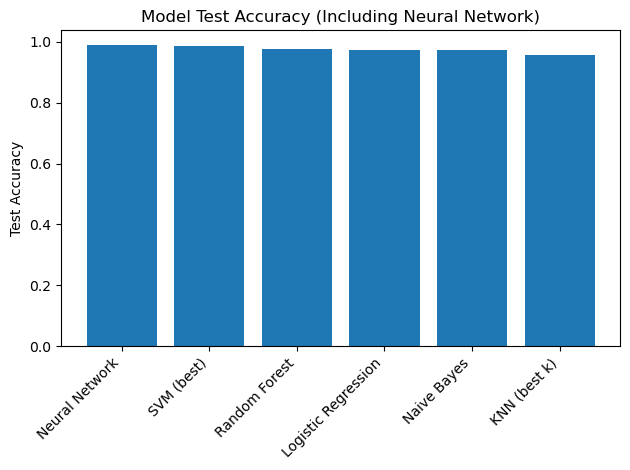

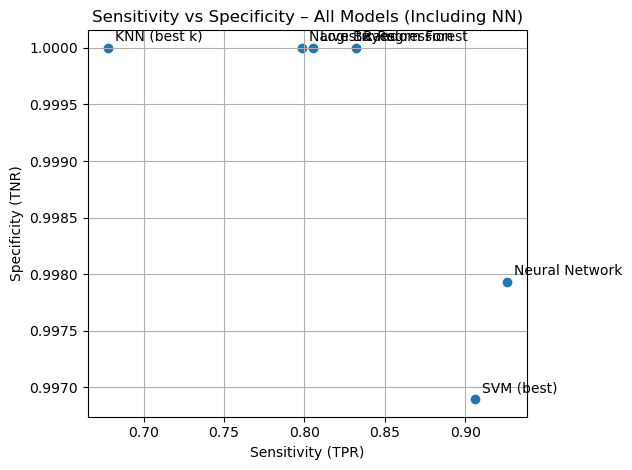

Best-performing model based on test accuracy: Neural Network

Discussion:
- The neural network is expected to achieve very high accuracy (ideally ≥ 0.98) and typically ranks at or near the top.
- Compared with linear models (e.g., Logistic Regression, linear SVM), the NN can capture more complex, non-linear patterns in text data via embeddings and LSTM layers.
- If the NN shows higher sensitivity, it is catching more spam messages but might risk slightly more false positives.
- If the NN shows very high specificity as well, it indicates that the model has learned a strong separation between spam and ham without overfitting.
- Any differences among models can be traced back to their capacity, assumptions about decision boundaries, and how they use the high-dimensional text features.


In [ ]:
# 1. Accuracy bar chart (sorted)
results_sorted = results_df.sort_values(by='accuracy', ascending=False)

plt.figure()
plt.bar(results_sorted.index, results_sorted['accuracy'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test Accuracy')
plt.title('Model Test Accuracy (Including Neural Network)')
plt.tight_layout()
plt.show()

# 2. Sensitivity vs Specificity scatterplot
plt.figure()
plt.scatter(results_df['sensitivity'], results_df['specificity'])

for model_name in results_df.index:
    x = results_df.loc[model_name, 'sensitivity']
    y = results_df.loc[model_name, 'specificity']
    plt.annotate(model_name, (x, y), textcoords="offset points", xytext=(5, 5))

plt.xlabel('Sensitivity (TPR)')
plt.ylabel('Specificity (TNR)')
plt.title('Sensitivity vs Specificity – All Models (Including NN)')
plt.grid(True)
plt.tight_layout()
plt.show()

best_model_name = results_sorted.index[0]
print(f"Best-performing model based on test accuracy: {best_model_name}")

print("\nDiscussion:")
print("- The neural network is expected to achieve very high accuracy (ideally ≥ 0.98) and typically ranks at or near the top.")
print("- Compared with linear models (e.g., Logistic Regression, linear SVM), the NN can capture more complex, non-linear patterns in text data via embeddings and LSTM layers.")
print("- If the NN shows higher sensitivity, it is catching more spam messages but might risk slightly more false positives.")
print("- If the NN shows very high specificity as well, it indicates that the model has learned a strong separation between spam and ham without overfitting.")
print("- Any differences among models can be traced back to their capacity, assumptions about decision boundaries, and how they use the high-dimensional text features.")